In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

Загружаем готовый csv с описанием компонента и энкодированным ТНВЭД кодом

In [2]:
data = pd.read_csv('data\\data.csv')

Посмотрим на распределение объектов по 85 классам:

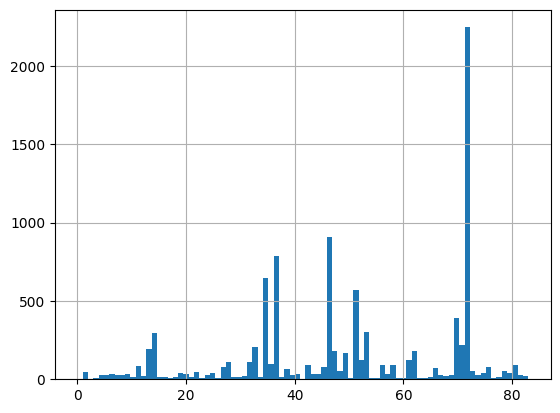

TNVED_encoded
72    2247
46     910
37     789
35     645
51     571
      ... 
55       8
59       6
3        5
0        3
2        1
Name: count, Length: 84, dtype: int64


In [3]:
data['TNVED_encoded'].hist(bins=85)
plt.show()
print(data['TNVED_encoded'].value_counts())

Формируем выборки и токенизируем текст

In [4]:
X = data['text'].to_list()
y = data['TNVED_encoded'].to_list()

X_train, X_temp, y_train, y_temp = train_test_split(
   X, y, test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128)


Собираем датасеты и даталоудеры

In [5]:


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, y_train)
val_dataset = CustomDataset(val_encodings, y_val)
test_dataset = CustomDataset(test_encodings, y_test)



train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [6]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=84)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [7]:
optimizer = AdamW(model.parameters(), lr=2e-5)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = CrossEntropyLoss(weight=class_weights)

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = criterion(logits,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


def validate_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            loss = criterion(logits,labels)
            total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return classification_report(y_true=y_true, y_pred=y_pred, labels=range(85))





In [8]:
best_val_loss = float('inf')
patience = 3
trigger_count = 0
for epoch in range(20):
    print(f"Epoch {epoch + 1}")
    avg_loss = train_epoch(model, train_loader, optimizer, device)
    print(f"Average Loss: {avg_loss}")

    val_loss = validate_model(model, val_loader, device)
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_count = 0
        model.save_pretrained("best_model_distilbert")
        
    else: 
        trigger_count+=1
        if trigger_count>patience: 
            print('!===Early stopping===!')
            break


    

Epoch 1


Training: 100%|██████████| 434/434 [03:16<00:00,  2.21it/s]


Average Loss: 3.8604982393677885


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.83it/s]


Validation Loss: 3.0427749977316907
Epoch 2


Training: 100%|██████████| 434/434 [03:18<00:00,  2.19it/s]


Average Loss: 2.4592593026600675


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.91it/s]


Validation Loss: 1.8964021269993117
Epoch 3


Training: 100%|██████████| 434/434 [03:20<00:00,  2.17it/s]


Average Loss: 1.542585368804668


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.92it/s]


Validation Loss: 1.2491773799542458
Epoch 4


Training: 100%|██████████| 434/434 [03:20<00:00,  2.16it/s]


Average Loss: 0.9913998044306233


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.87it/s]


Validation Loss: 0.9259789983431498
Epoch 5


Training: 100%|██████████| 434/434 [03:20<00:00,  2.16it/s]


Average Loss: 0.6667011192386052


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.88it/s]


Validation Loss: 0.7327475113573895
Epoch 6


Training: 100%|██████████| 434/434 [03:21<00:00,  2.16it/s]


Average Loss: 0.44883954528427344


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.95it/s]


Validation Loss: 0.6403483270957906
Epoch 7


Training: 100%|██████████| 434/434 [03:21<00:00,  2.15it/s]


Average Loss: 0.3064695886563733


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.91it/s]


Validation Loss: 0.5516464147035793
Epoch 8


Training: 100%|██████████| 434/434 [03:21<00:00,  2.15it/s]


Average Loss: 0.20683348051825975


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.91it/s]


Validation Loss: 0.5477591208632915
Epoch 9


Training: 100%|██████████| 434/434 [03:21<00:00,  2.16it/s]


Average Loss: 0.1552946421957236


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.91it/s]


Validation Loss: 0.46969778711597127
Epoch 10


Training: 100%|██████████| 434/434 [03:21<00:00,  2.16it/s]


Average Loss: 0.11278923555418918


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.97it/s]


Validation Loss: 0.5318537664509588
Epoch 11


Training: 100%|██████████| 434/434 [03:20<00:00,  2.16it/s]


Average Loss: 0.09333743715512863


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.94it/s]


Validation Loss: 0.5112977033400888
Epoch 12


Training: 100%|██████████| 434/434 [03:20<00:00,  2.16it/s]


Average Loss: 0.06840593625752744


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.94it/s]


Validation Loss: 0.4734157392935407
Epoch 13


Training: 100%|██████████| 434/434 [03:20<00:00,  2.17it/s]


Average Loss: 0.04613961536257017


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.94it/s]

Validation Loss: 0.49557076677960415
!===Early stopping===!


In [9]:

report_distill_bert = evaluate_model(model, test_loader, device)
print(report_distill_bert)


Evaluating: 100%|██████████| 93/93 [00:15<00:00,  5.94it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.80      0.73         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         2
           5       1.00      0.75      0.86         4
           6       1.00      0.86      0.92         7
           7       1.00      0.67      0.80         3
           8       0.60      1.00      0.75         3
           9       0.75      0.86      0.80         7
          10       0.50      1.00      0.67         1
          11       0.80      0.86      0.83        14
          12       0.50      1.00      0.67         1
          13       0.96      0.92      0.94        26
          14       1.00      0.98      0.99        47
          15       0.67      1.00      0.80         2
          16       0.00      0.00      0.00         1
          17       0.00    


c:\Users\Shamaich\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shamaich\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shamaich\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

                 precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.80      0.73         5
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         2
           5       1.00      0.75      0.86         4
           6       1.00      0.86      0.92         7
           7       1.00      0.67      0.80         3
           8       0.60      1.00      0.75         3
           9       0.75      0.86      0.80         7
          10       0.50      1.00      0.67         1
          11       0.80      0.86      0.83        14
          12       0.50      1.00      0.67         1
          13       0.96      0.92      0.94        26
          14       1.00      0.98      0.99        47
          15       0.67      1.00      0.80         2
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       1.00      1.00      1.00         2
          19       1.00      0.88      0.93         8
          20       0.67      0.67      0.67         3
          21       1.00      1.00      1.00         3
          22       1.00      1.00      1.00         8
          23       0.00      0.00      0.00         1
          24       1.00      0.67      0.80         3
          25       0.80      0.80      0.80         5
          26       0.67      1.00      0.80         2
          27       1.00      1.00      1.00         9
          28       0.94      1.00      0.97        17
          29       0.00      0.00      0.00         1
          30       0.00      0.00      0.00         0
          31       0.75      1.00      0.86         3
          32       1.00      1.00      1.00        17
          33       0.97      0.97      0.97        35
          34       0.00      0.00      0.00         2
          35       1.00      1.00      1.00        82
          36       0.75      0.90      0.82        10
          37       1.00      0.99      1.00       123
          38       0.00      0.00      0.00         0
          39       1.00      0.88      0.93        16
          40       1.00      1.00      1.00         4
          41       0.83      1.00      0.91         5
          42       1.00      1.00      1.00         5
          43       0.50      0.67      0.57         3
          44       1.00      0.60      0.75         5
          45       0.82      0.82      0.82        11
          46       0.91      0.83      0.87       145
          47       0.58      0.71      0.64        35
          48       1.00      0.57      0.73         7
          49       0.74      0.76      0.75        38
          50       0.00      0.00      0.00         1
          51       0.97      0.88      0.92        96
          52       0.69      0.58      0.63        19
          53       0.82      0.96      0.89        49
          54       1.00      1.00      1.00         2
          55       0.00      0.00      0.00         0
          56       1.00      1.00      1.00        12
          57       1.00      1.00      1.00         4
          58       0.82      1.00      0.90        14
          59       0.00      0.00      0.00         1
          60       0.00      0.00      0.00         0
          61       1.00      0.86      0.92        21
          62       1.00      1.00      1.00        22
          63       1.00      0.75      0.86         4
          64       0.33      1.00      0.50         1
          65       0.75      1.00      0.86         3
          66       0.78      1.00      0.88         7
          67       1.00      0.80      0.89         5
          68       1.00      0.86      0.92         7
          69       1.00      1.00      1.00         5
          70       0.95      0.98      0.97        64
          71       0.92      0.92      0.92        36
          72       0.98      0.96      0.97       331
          73       0.62      1.00      0.76         8
          74       1.00      0.75      0.86         4
          75       0.50      1.00      0.67         2
          76       1.00      1.00      1.00         7
          77       0.00      0.00      0.00         0
          78       0.50      1.00      0.67         2
          79       1.00      0.80      0.89         5
          80       1.00      1.00      1.00         3
          81       0.89      1.00      0.94         8
          82       1.00      0.88      0.93         8
          83       1.00      1.00      1.00         5
          84       0.00      0.00      0.00         0

    accuracy                           0.91      1488
    macro avg      0.70      0.73      0.70      1488
    weighted avg   0.93      0.91      0.92      1488

